In [1]:
!git clone https://github.com/kairosfuture/dcipher-nlp-challenge.git
!pip install transformers
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Cloning into 'dcipher-nlp-challenge'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 22 (delta 9), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (22/22), done.
     |████████████████████████████████| 1.5MB 9.0MB/s 
     |████████████████████████████████| 890kB 29.8MB/s 
     |████████████████████████████████| 2.9MB 42.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=c012d266a851e0750517ded1b3fbbe12bcec629e35325d066fef48bdeb5b1078
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 51kB 6.0MB/s 
Looking in indexes: https://test.pypi.org/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import pandas as pd   
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [4]:
file = '/content/dcipher-nlp-challenge/data/wos2class.json'
with open(file) as df:
    dict_train = json.load(df)

df = pd.DataFrame.from_dict(dict_train)
print(df.shape)
print(df.isna().sum())

df.drop(df[df['Abstract'].str.len() < 10].index, inplace=True)
df['title_abstract'] = df['Title'] + ". " + df['Abstract']
df['Label'] = (df['Label'] == 'Material Science').astype('int')

print(df['Label'].value_counts(normalize=True))

(7494, 3)
Title       0
Abstract    0
Label       0
dtype: int64
1    0.506072
0    0.493928
Name: Label, dtype: float64


In [5]:
train, test, y_train, y_test = train_test_split(df['title_abstract'],
                                                df['Label'],
                                                test_size=0.2,
                                                random_state=42,
                                                stratify=df['Label'])

train, val, y_train, y_val = train_test_split(train,
                                              y_train,
                                              test_size=0.2,
                                              random_state=42,
                                              stratify=y_train)

'''
df_train = pd.concat([train, y_train], ignore_index=True, sort=False, axis=1)
df_val = pd.concat([val, y_val], ignore_index=True, sort=False, axis=1)
df_test = pd.concat([test, y_test], ignore_index=True, sort=False, axis=1)

df_train.to_csv('train.csv', index=False)
df_val.to_csv('valid.csv', index=False)
df_test.to_csv('test.csv', index=False)
'''

"\ndf_train = pd.concat([train, y_train], ignore_index=True, sort=False, axis=1)\ndf_val = pd.concat([val, y_val], ignore_index=True, sort=False, axis=1)\ndf_test = pd.concat([test, y_test], ignore_index=True, sort=False, axis=1)\n\ndf_train.to_csv('train.csv', index=False)\ndf_val.to_csv('valid.csv', index=False)\ndf_test.to_csv('test.csv', index=False)\n"

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True
seed = 17
torch.manual_seed(seed)

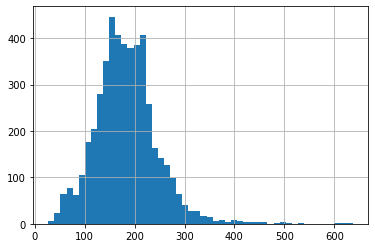

In [7]:
seq_len = [len(i.split()) for i in train]
pd.Series(seq_len).hist(bins=50)
max_seq_len = 512

In [8]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

tokens_train = tokenizer.batch_encode_plus(train.tolist(),
                                           max_length=max_seq_len,
                                           padding=True,
                                           truncation=True,
                                           return_token_type_ids=False)

tokens_val = tokenizer.batch_encode_plus(val.tolist(),
                                         max_length=max_seq_len,
                                         padding=True,
                                         truncation=True,
                                         return_token_type_ids=False)

tokens_test = tokenizer.batch_encode_plus(test.tolist(),
                                          max_length=max_seq_len,
                                          padding=True,
                                          truncation=True,
                                          return_token_type_ids=False)

In [9]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [10]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

batch_size = 12

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data,
                            sampler=val_sampler,
                            batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data,
                             sampler=test_sampler,
                             batch_size=3)

In [11]:
model = AutoModelForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased',
                                                      num_labels=2)
model = model.to(device)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [12]:
from transformers import AdamW

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(model.parameters(), lr=5e-7)

In [13]:
def train():

    model.train()
    total_loss, epoch_acc = 0, 0

    for step, batch in enumerate(train_dataloader):

        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()

        labels = torch.tensor(labels).unsqueeze(0)
        output = model(sent_id, mask, labels=labels, return_dict=True)
        loss = output.loss
        preds = output.logits.squeeze().float()

        labels = labels.squeeze().long()
        preds = torch.argmax(preds, axis=1)
        correct = (preds == labels).float()
        acc = correct.sum() / len(correct)
        epoch_acc += acc.item()
        total_loss = total_loss + loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)

    return avg_loss, epoch_acc/len(train_dataloader)


In [14]:
def evaluate():

    print("\nEvaluating...")

    model.eval()
    total_loss, epoch_acc = 0, 0

    for step,batch in enumerate(val_dataloader):
    
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
          
            labels = torch.tensor(labels).unsqueeze(0)
            output = model(sent_id, mask, labels=labels, return_dict=True)
            loss = output.loss
            preds = output.logits.squeeze().float()
            labels = labels.squeeze().long()

            preds = torch.argmax(preds, axis = 1)
            correct = (preds == labels).float() 
            acc = correct.sum() / len(correct)
            epoch_acc += acc.item()
            total_loss = total_loss + loss.item()

    avg_loss = total_loss / len(val_dataloader) 

    return avg_loss, epoch_acc/len(val_dataloader)

In [15]:
epochs = 20
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, train_acc = train()

    valid_loss, valid_acc = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/weights_dcipher/scibert_fine_tune_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


 Epoch 1 / 20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Batch    50 of   400.
Batch   100 of   400.
Batch   150 of   400.
Batch   200 of   400.
Batch   250 of   400.
Batch   300 of   400.
Batch   350 of   400.

Evaluating...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  Batch    50  of    100.
	Train Loss: 0.649 | Train Acc: 60.30%
	 Val. Loss: 0.596 |  Val. Acc: 65.15%

 Epoch 2 / 20
Batch    50 of   400.
Batch   100 of   400.
Batch   150 of   400.
Batch   200 of   400.
Batch   250 of   400.
Batch   300 of   400.
Batch   350 of   400.

Evaluating...
  Batch    50  of    100.
	Train Loss: 0.594 | Train Acc: 66.95%
	 Val. Loss: 0.561 |  Val. Acc: 68.08%

 Epoch 3 / 20
Batch    50 of   400.
Batch   100 of   400.
Batch   150 of   400.
Batch   200 of   400.
Batch   250 of   400.
Batch   300 of   400.
Batch   350 of   400.

Evaluating...
  Batch    50  of    100.
	Train Loss: 0.559 | Train Acc: 70.46%
	 Val. Loss: 0.538 |  Val. Acc: 71.33%

 Epoch 4 / 20
Batch    50 of   400.
Batch   100 of   400.
Batch   150 of   400.
Batch   200 of   400.
Batch   250 of   400.
Batch   300 of   400.
Batch   350 of   400.

Evaluating...
  Batch    50  of    100.
	Train Loss: 0.541 | Train Acc: 71.10%
	 Val. Loss: 0.524 |  Val. Acc: 72.41%

 Epoch 5 / 20
Batch    50 of   

KeyboardInterrupt: ignored

In [16]:
with torch.no_grad():
    torch.cuda.empty_cache()
path = '/content/drive/MyDrive/weights_dcipher/scibert_fine_tune_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [19]:
preds = []
probas_0 = []
probas_1 = []

for i, batch in enumerate(test_dataloader):

    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    with torch.no_grad():
        output = model(sent_id, mask)
        pred = output.logits.squeeze().float()
        probas_0.extend(pred[: , 0:1].squeeze().float().detach().cpu().numpy())
        probas_1.extend(pred[: , 1:2].squeeze().float().detach().cpu().numpy())
        pred = torch.argmax(pred, axis=1)
        pred = pred.squeeze().float().detach().cpu().numpy()
        preds.extend(pred)

preds = np.asarray(preds)
print(classification_report(test_y, preds))
pd.crosstab(test_y, preds)

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       740
           1       0.73      0.76      0.75       759

    accuracy                           0.74      1499
   macro avg       0.74      0.74      0.74      1499
weighted avg       0.74      0.74      0.74      1499



col_0,0.0,1.0
row_0,,
0,526,214
1,181,578


Class 1: ROC AUC = 0.831
F1 Score = 0.745
Accuracy = 0.736


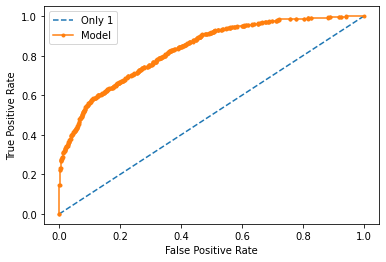

In [21]:
auc_1 = roc_auc_score(test_y, probas_1)

print('Class 1: ROC AUC = %.3f' % (auc_1))

f1 = f1_score(test_y, preds)
print('F1 Score = %.3f' % (f1))

acc = accuracy_score(test_y, preds)
print('Accuracy = %.3f' % (acc))

ns_1 = [1 for _ in range(len(test_y))]

fpr_0, tpr_0, _ = roc_curve(test_y, probas_0)
fpr_1, tpr_1, _ = roc_curve(test_y, probas_1)
fpr_ns_1, tpr_ns_1, _ =  roc_curve(test_y, ns_1)

pyplot.plot(fpr_ns_1, tpr_ns_1, linestyle='--', label='Only 1')
pyplot.plot(fpr_1, tpr_1, marker='.', label='Model')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()